In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.style as stl 
from tqdm import tqdm
from tensorflow import keras 
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
import string
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
import warnings
warnings.filterwarnings('ignore')
stl.use('ggplot')

In [2]:
data=pd.read_csv("../input/sample/sample-2.csv")

In [3]:
data.head()

,document_id,status,document_url,media_type,media_link,relative_media_path,is_media_downloaded,transcription_text,transcription_text_relative_path,from_time,to_time,project_id,Category,Unnamed: 13,Unnamed: 14
0,NMAAHC-007676813_00577,Complete,https://transcription.si.edu/transcribe/32203/...,image,https://ids.si.edu/ids/deliveryService?max_w=&...,/32203/image/NMAAHC-007676813_00577.jpg,1,"8 E encl\r\n\r\nI Anne H. Elliott, widow do so...",/32203/transcriptions/NMAAHC-007676813_00577.txt,\N,\N,32203,Oaths/Pardons,NaN,NaN
1,NMAAHC-007676818_00567,Complete,https://transcription.si.edu/transcribe/32796/...,image,https://ids.si.edu/ids/deliveryService?max_w=&...,/32796/image/NMAAHC-007676818_00567.jpg,1,I E C Whaley solemnly swear that I have carefu...,/32796/transcriptions/NMAAHC-007676818_00567.txt,\N,\N,32796,Oaths/Pardons,NaN,NaN
2,NMAAHC-007676815_00488-000001,Complete,https://transcription.si.edu/transcribe/32218/...,image,https://ids.si.edu/ids/deliveryService?max_w=&...,/32218/image/NMAAHC-007676815_00488-000001.jpg,1,43M\r\nI Mrs E Montgomery solemnly Swear that ...,/32218/transcriptions/NMAAHC-007676815_00488-0...,\N,\N,32218,Oaths/Pardons,NaN,NaN
3,NMAAHC-007677400_00375,Complete,https://transcription.si.edu/transcribe/26149/...,image,https://ids.si.edu/ids/deliveryService?max_w=&...,/26149/image/NMAAHC-007677400_00375.jpg,1,"No. 2324\r\nI do solemnly swear or affirm, in ...",/26149/transcriptions/NMAAHC-007677400_00375.txt,\N,\N,26149,Oaths/Pardons,NaN,NaN
4,NMAAHC-007677378_00480,Complete,https://transcription.si.edu/transcribe/27345/...,image,https://ids.si.edu/ids/deliveryService?max_w=&...,/27345/image/NMAAHC-007677378_00480.jpg,1,August 24. 1865\r\nAPPLICATION AND CERTIFICATE...,/27345/transcriptions/NMAAHC-007677378_00480.txt,\N,\N,27345,Oaths/Pardons,NaN,NaN


In [4]:
data["transcription_text"][1]

'I E C Whaley solemnly swear that I have carefully read the Amnesty\r\nProclamation issued by Andrew Johnson, President of the United State of America, on May 29th, 1865, and that I am not excepted from the benefits of the Proclamation by any one of the fourteen exceptions therein made [[Strikethrough]] except [[strikethrough/]] \r\nE C Whaley\r\nSworn to and subscribed before me at Charleston SC this 28\r\nday of Sept 1865\r\n\r\nLevi Steuben\r\nMaj. 47th P.M.\r\n\r\nUnited States of America\r\nE C Whaley of the city [[strikethrough]] county [[strikethrough/]] Charleston Sate of South Ca do solemnly swear in the presence of the Almighty God, that I will henceforth faithfully support and defend the Constitution of the United States, and the Union of the States thereunder, and that I will, in like manner, abide by and faithfully support all laws and proclamations which have been made during the existing rebellion with reference to the Emancipation of Slaves-SO HELP ME GOD\r\n\r\nE C Wha

In [5]:
text=data["transcription_text"]

*extract transcription_text from the dataset*

In [6]:
text.head()

0    8 E encl\r\n\r\nI Anne H. Elliott, widow do so...
1    I E C Whaley solemnly swear that I have carefu...
2    43M\r\nI Mrs E Montgomery solemnly Swear that ...
3    No. 2324\r\nI do solemnly swear or affirm, in ...
4    August 24. 1865\r\nAPPLICATION AND CERTIFICATE...
Name: transcription_text, dtype: object

*trying nltk*

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

extract token from each paragraph

In [8]:
tokens=[word for word in nltk.word_tokenize(text[1])]

In [9]:
tokens[:10]

['I',
 'E',
 'C',
 'Whaley',
 'solemnly',
 'swear',
 'that',
 'I',
 'have',
 'carefully']

**position tag of each token**

In [10]:
 word_tag = nltk.pos_tag(tokens)

In [11]:
word_tag[:10]

[('I', 'PRP'),
 ('E', 'VBP'),
 ('C', 'NNP'),
 ('Whaley', 'NNP'),
 ('solemnly', 'RB'),
 ('swear', 'VBP'),
 ('that', 'IN'),
 ('I', 'PRP'),
 ('have', 'VBP'),
 ('carefully', 'RB')]

****

**transforming the tree tag to column tag and adding iob (in, out, begin) tag**

In [12]:
from nltk.chunk import  tree2conlltags
iob_tag = tree2conlltags(word_tag)
iob_tag[:5]

[('I', 'PRP', 'O'),
 ('E', 'VBP', 'O'),
 ('C', 'NNP', 'O'),
 ('Whaley', 'NNP', 'O'),
 ('solemnly', 'RB', 'O')]

**creating dataframe from extracted entities and their position tag  for using it later**

In [13]:
l1=[]
l2=[]
l3=[]
for i in range(20):
    l1.append(iob_tag[i][0])
    l2.append(iob_tag[i][1])
    l3.append(iob_tag[i][2])

In [14]:
df=pd.DataFrame({"entities":l1, "pos_tag": l2, "iob_tag":l3})

In [15]:
df.head()

,entities,pos_tag,iob_tag
0,I,PRP,O
1,E,VBP,O
2,C,NNP,O
3,Whaley,NNP,O
4,solemnly,RB,O


**trying other method like ne_chunk , it can be more accurate and helpful in term of identifying of PERSON ORGANIZATION and GPE**

In [16]:
ne_tree = nltk.ne_chunk(pos_tag(word_tokenize(text[10])))
print(ne_tree[:10])

[('[', 'NN'), ('[', 'NNP'), ('image', 'NN'), ('-', ':'), ('eagle', 'NN'), (']', 'NN'), (']', 'NNP'), ('AMNESTY', 'NNP'), ('OATH', 'NNP'), ('.', '.')]


# Spacy

*SpaCy’s named entity recognition has been trained on the OntoNotes 5 corpus and it supports the following entity types:*

![](https://miro.medium.com/max/1400/1*qQggIPMugLcy-ndJ8X_aAA.png)

importing the necessary libraries

In [17]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

**trying to extract all useful information about the entity in text  from Doc(nlp(text) like : the entity | the lemmatization of the entity | the label of the entity and the explanation of the label**

In [18]:
L1=[]
def NER (txt):
    for i in range(20):
        nlp_text=nlp(txt[i])
        L1.append([(word.text,word.lemma_, word.start_char, word.end_char, word.label_,spacy.explain(word.label_)) for word in nlp_text.ents])

In [19]:
L2=[]
def NER1 (txt):
    for i in range(20):
        nlp_text=nlp(txt[i])
        L2.append([(word,word.lemma_, word.ent_iob_, word.ent_type_, word.pos) for word in nlp_text])

In [20]:
NER(text)
NER1(text)

In [21]:
L1[0]

[('Anne H. Elliott',
  'Anne H. Elliott',
  14,
  29,
  'PERSON',
  'People, including fictional'),
 ('Amnesty',
  'Amnesty',
  76,
  83,
  'ORG',
  'Companies, agencies, institutions, etc.'),
 ('Andrew Johnson',
  'Andrew Johnson',
  107,
  121,
  'PERSON',
  'People, including fictional'),
 ('the United States of America',
  'the United States of America',
  135,
  163,
  'GPE',
  'Countries, cities, states'),
 ('May 29th 1865',
  'May 29th 1865',
  167,
  180,
  'DATE',
  'Absolute or relative dates or periods'),
 ('one',
  'one',
  254,
  257,
  'CARDINAL',
  'Numerals that do not fall under another type'),
 ('fourteen',
  'fourteen',
  265,
  273,
  'CARDINAL',
  'Numerals that do not fall under another type'),
 ('1865', '1865', 358, 362, 'DATE', 'Absolute or relative dates or periods'),
 ('S. Wilde Durson',
  'S. Wilde Durson',
  364,
  379,
  'PERSON',
  'People, including fictional'),
 ('Magt', 'Magt', 381, 385, 'GPE', 'Countries, cities, states'),
 ('2 cent', '2 cent', 409, 41

**structered the extracted information in a dataframe for using it in the next stage**

In [22]:
l0=[]
l1=[]
l2=[]
l3=[]
l4=[]
l5=[]
for i in range(len(L1)):
    for j in range(len(L1[i])):
        l0.append(L1[i][j][0])
        l1.append(L1[i][j][1])
        l2.append(L1[i][j][2])
        l3.append(L1[i][j][3])
        l4.append(L1[i][j][4])
        l5.append(L1[i][j][5])
   

In [23]:
df1=pd.DataFrame({"entities":l0, "lemmatization": l1,"start_char":l2,"end_char":l3 ,"label": l4, "explain": l5, "frequency":""})
df1.head()


,entities,lemmatization,start_char,end_char,label,explain,frequency
0,Anne H. Elliott,Anne H. Elliott,14,29,PERSON,"People, including fictional",
1,Amnesty,Amnesty,76,83,ORG,"Companies, agencies, institutions, etc.",
2,Andrew Johnson,Andrew Johnson,107,121,PERSON,"People, including fictional",
3,the United States of America,the United States of America,135,163,GPE,"Countries, cities, states",
4,May 29th 1865,May 29th 1865,167,180,DATE,Absolute or relative dates or periods,


In [24]:
df1.shape

(394, 7)

**adding the frequency of each entities in the text maybe it may help in improving the model later**

In [25]:
Counter(df1["entities"][:10])

Counter({'Anne H. Elliott': 1,
         'Amnesty': 1,
         'Andrew Johnson': 1,
         'the United States of America': 1,
         'May 29th 1865': 1,
         'one': 1,
         'fourteen': 1,
         '1865': 1,
         'S. Wilde Durson': 1,
         'Magt': 1})

In [26]:
dict=Counter(df1["entities"])

In [27]:
for i in range(df1.shape[0]):
    df1["frequency"][i]=dict[df1["entities"].loc[i]]

In [28]:
df1

,entities,lemmatization,start_char,end_char,label,explain,frequency
0,Anne H. Elliott,Anne H. Elliott,14,29,PERSON,"People, including fictional",1
1,Amnesty,Amnesty,76,83,ORG,"Companies, agencies, institutions, etc.",2
2,Andrew Johnson,Andrew Johnson,107,121,PERSON,"People, including fictional",2
3,the United States of America,the United States of America,135,163,GPE,"Countries, cities, states",7
4,May 29th 1865,May 29th 1865,167,180,DATE,Absolute or relative dates or periods,1
...,...,...,...,...,...,...,...
389,Warren Co Miss,Warren Co Miss,985,999,PERSON,"People, including fictional",1
390,1865,1865,1033,1037,DATE,Absolute or relative dates or periods,14
391,Frank E. Miller,Frank E. Miller,1042,1057,PERSON,"People, including fictional",2
392,66th,66th,1065,1069,ORDINAL,"""first"", ""second"", etc.",3


In [29]:
df1["entities"].loc[1]

'Amnesty'

In [30]:
L2[1][:5]

[(I, 'I', 'O', '', 95),
 (E, 'e', 'O', '', 92),
 (C, 'C', 'O', '', 96),
 (Whaley, 'Whaley', 'B', 'PERSON', 96),
 (solemnly, 'solemnly', 'O', '', 86)]

In [31]:
L2[0][:10]

[(8, '8', 'O', '', 93),
 (E, 'e', 'O', '', 92),
 (encl, 'encl', 'O', '', 92),
 (
  , '\r\n\r\n', 'O', '', 103),
 (I, 'i', 'O', '', 100),
 (Anne, 'Anne', 'B', 'PERSON', 96),
 (H., 'H.', 'I', 'PERSON', 96),
 (Elliott, 'Elliott', 'I', 'PERSON', 96),
 (,, ',', 'O', '', 97),
 (widow, 'widow', 'O', '', 92)]

In [32]:
l1=[]
l2=[]
l3=[]
l4=[]
for i in range(20):
    for j in range(len(L2[i])):
        l1.append(L2[i][j][0])
        l2.append(L2[i][j][1])
        l3.append(L2[i][j][2])
        l4.append(L2[i][j][3])

In [33]:
df2=pd.DataFrame({"entities":l1,"lemmatizaton":l2, "iob_tag": l3, "label":l4, "pos_tag": "", "explain_tag":"","relationship": ""})
df2.head(10)


,entities,lemmatizaton,iob_tag,label,pos_tag,explain_tag,relationship
0,8,8,O,,,,
1,E,e,O,,,,
2,encl,encl,O,,,,
3,\r\n\r\n,\r\n\r\n,O,,,,
4,I,i,O,,,,
5,Anne,Anne,B,PERSON,,,
6,H.,H.,I,PERSON,,,
7,Elliott,Elliott,I,PERSON,,,
8,",",",",O,,,,
9,widow,widow,O,,,,


**adding pos_tag and its explanation to the dataframe to be more simpl and easy to understand**

In [34]:
L=[]
t=[]
for i in range(df2.shape[0]) :
    x = df2["entities"].loc[i]
    L.append((x.pos_))
    t.append(spacy.explain(x.tag_))
    df2["pos_tag"].loc[i]=L[i]
    df2["explain_tag"].loc[i]=t[i]

In [35]:
df2

,entities,lemmatizaton,iob_tag,label,pos_tag,explain_tag,relationship
0,8,8,O,,NUM,cardinal number,
1,E,e,O,,NOUN,"noun, singular or mass",
2,encl,encl,O,,NOUN,"noun, singular or mass",
3,\r\n\r\n,\r\n\r\n,O,,SPACE,whitespace,
4,I,i,O,,VERB,"verb, non-3rd person singular present",
...,...,...,...,...,...,...,...
3761,\r\n\r\n,\r\n\r\n,O,,SPACE,whitespace,
3762,[,[,O,,X,unknown,
3763,DUPLICATE,duplicate,O,,X,unknown,
3764,],],O,,PUNCT,right round bracket,


**extract the relationship of the entity with its parent (dep_)**

In [36]:
L=[]
for i in range(df2.shape[0]) :
    x = df2["entities"].loc[i]
    L.append((x.dep_))
    df2["relationship"].loc[i]=L[i]

In [37]:
df2

,entities,lemmatizaton,iob_tag,label,pos_tag,explain_tag,relationship
0,8,8,O,,NUM,cardinal number,nummod
1,E,e,O,,NOUN,"noun, singular or mass",compound
2,encl,encl,O,,NOUN,"noun, singular or mass",nsubj
3,\r\n\r\n,\r\n\r\n,O,,SPACE,whitespace,dep
4,I,i,O,,VERB,"verb, non-3rd person singular present",punct
...,...,...,...,...,...,...,...
3761,\r\n\r\n,\r\n\r\n,O,,SPACE,whitespace,dep
3762,[,[,O,,X,unknown,punct
3763,DUPLICATE,duplicate,O,,X,unknown,appos
3764,],],O,,PUNCT,right round bracket,punct


trying to more understand the use  and the advantages of display_render in spacy 

In [38]:
sentences = [x for x in nlp(text[1]).sents]
print(sentences)

[I E C Whaley solemnly swear that I have carefully read the Amnesty
Proclamation issued by Andrew Johnson, President of the United State of America, on May 29th, 1865, and that I am not excepted from the benefits of the Proclamation by any one of the fourteen exceptions therein made [[Strikethrough]] except [[strikethrough/]] 
E C Whaley
Sworn to and subscribed before me at Charleston SC this 28
day of Sept 1865

Levi Steuben
Maj. 47th P.M.

United States of America
E C Whaley of the city, [[strikethrough]] county [[strikethrough/]] Charleston Sate of South Ca do solemnly swear in the presence of the Almighty God, that I will henceforth faithfully support and defend the Constitution of the United States, and the Union of the States thereunder, and that I will, in like manner, abide by and faithfully support all laws and proclamations which have been made during the existing rebellion with reference to the Emancipation of Slaves-SO HELP ME GOD

E C Whaley
Sworn to and subscribed before 

In [39]:
displacy.render(nlp(str(df1.entities)), style='ent')

In [40]:
displacy.render(nlp(str(sentences)) , style='ent')

**extracting sentences with spacy and their interest in NER**

In [41]:
doc=nlp(text[1])
sentences=list(doc.sents)

In [42]:
len(sentences)

3

In [43]:
for sent in sentences:
    print(type(sent))
    print(sent)

<class 'spacy.tokens.span.Span'>
I E C Whaley solemnly swear that I have carefully read the Amnesty
Proclamation issued by Andrew Johnson, President of the United State of America, on May 29th, 1865, and that I am not excepted from the benefits of the Proclamation by any one of the fourteen exceptions therein made [[Strikethrough]] except [[strikethrough/]] 
E C Whaley
Sworn to and subscribed before me at Charleston SC this 28
day of Sept 1865

Levi Steuben
Maj. 47th P.M.

United States of America
E C Whaley of the city
<class 'spacy.tokens.span.Span'>
[[strikethrough]] county [[strikethrough/]] Charleston Sate of South Ca do solemnly swear in the presence of the Almighty God, that I will henceforth faithfully support and defend the Constitution of the United States, and the Union of the States thereunder, and that I will, in like manner, abide by and faithfully support all laws and proclamations which have been made during the existing rebellion with reference to the Emancipation of S

In [44]:
for word in doc.ents:
    print(word.text, word.start_char, word.end_char, word.label_)
    

Whaley 6 12 PERSON
Amnesty 59 66 ORG
Andrew Johnson 91 105 PERSON
the United State of America 120 147 ORG
May 29th, 1865 152 166 DATE
Proclamation 220 232 LOC
one 240 243 CARDINAL
fourteen 251 259 CARDINAL
C Whaley 332 340 ORG
Charleston SC 379 392 ORG
this 28
day of 393 408 DATE
Sept 1865 409 418 DATE
Levi Steuben 422 434 PERSON
47th 441 445 ORDINAL
P.M. 446 450 GPE
United States of America 454 478 GPE
Whaley 484 490 PERSON
the United States 703 720 GPE
the Union of the States 726 749 ORG
the Emancipation of Slaves-SO 923 952 ORG
C Whaley 970 978 ORG
Charleston SC 1017 1030 ORG
this 28
day of 1031 1046 DATE
Sept 1865 1047 1056 DATE
Levi Steuben 1060 1072 PERSON
May 47 1074 1080 DATE
P.M. 1081 1085 NORP
5 feet 10
inches 1147 1164 MONEY
39 years 1174 1182 DATE
Oaths 1227 1232 PERSON
the Department of State 1292 1315 ORG
Levi Steuben 1477 1489 PERSON
47th 1495 1499 ORDINAL
City of Charleston 1513 1531 ORG


**Similarity**

In [45]:
nlp = spacy.load("en_core_web_lg")
tokens = nlp(text[1])

*Spacy also provides inbuilt integration of dense, real valued vectors representing distributional similarity information.
Models that come with built-in word vectors make them available as the Token.vector attribute. Doc.vector and Span.vector will default to an average of their token vectors. You can also check if a token has a vector assigned, and get the L2 norm, which can be used to normalize vectors.*

In [46]:
for token in tokens[:10]:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

I True 6.4231944 False
E True 7.0117927 False
C True 6.1874003 False
Whaley True 7.778265 False
solemnly True 6.533941 False
swear True 5.3750224 False
that True 4.8260193 False
I True 6.4231944 False
have True 5.036123 False
carefully True 6.058085 False


**calculate similarity between tokens**

In [47]:
for token1 in tokens[:10]:
    for token2 in tokens[:10]:
        print(token1.text, token2.text, token1.similarity(token2))

I I 1.0
I E 0.3861718475818634
I C 0.35280120372772217
I Whaley -0.036032456904649734
I solemnly 0.13830667734146118
I swear 0.5402541756629944
I that 0.45158401131629944
I I 1.0
I have 0.5313224196434021
I carefully 0.26356905698776245
E I 0.3861718475818634
E E 1.0
E C 0.5150542855262756
E Whaley -0.0038583450950682163
E solemnly 0.007434697821736336
E swear 0.12622001767158508
E that 0.15877665579319
E I 0.3861718475818634
E have 0.1498286873102188
E carefully 0.05362604558467865
C I 0.35280120372772217
C E 0.5150542855262756
C C 1.0
C Whaley -0.00789939146488905
C solemnly 0.032800860702991486
C swear 0.1354278326034546
C that 0.17746229469776154
C I 0.35280120372772217
C have 0.13458862900733948
C carefully 0.11058475822210312
Whaley I -0.036032456904649734
Whaley E -0.0038583450950682163
Whaley C -0.00789939146488905
Whaley Whaley 1.0
Whaley solemnly 0.060280606150627136
Whaley swear -0.08309495449066162
Whaley that -0.25064030289649963
Whaley I -0.036032456904649734
Whaley have 

awesome!

# Embedding

<h2>word2vec </h2>

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

In [48]:
from gensim.models import Word2Vec
tokens = text.apply(lambda x: nltk.word_tokenize(x))

In [49]:
w2v_model = Word2Vec(min_count=1,
                     window=10,
                     vector_size=100,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     negative=20,
                     seed = 42)

In [50]:
w2v_model.build_vocab(tokens, progress_per=1000)

In [51]:
w2v_model

**train the model**

In [52]:
w2v_model.train(tokens, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)

(44302, 71200)

we are calling init_sims(), which will make the model much more memory-efficient:

In [53]:
w2v_model.init_sims(replace=True)

In [54]:
v1 = w2v_model.wv['swear']
print(v1)

[-0.04951133  0.11050034  0.06967741  0.01490528 -0.14971273  0.13183625
  0.16652586  0.18385077 -0.12037469 -0.03434359 -0.15926217 -0.00971843
 -0.03694363  0.13860089  0.05176211  0.06452275  0.00438655 -0.12337547
 -0.10607462 -0.0390372  -0.04318861  0.13785346  0.16397966  0.06532136
  0.11919588 -0.03828365  0.01789892  0.06706134 -0.03277326 -0.1054505
 -0.20866978  0.09919342 -0.09137964  0.05076228  0.0548308  -0.04937703
 -0.0408196  -0.04357161  0.05971956  0.08942538  0.06713237  0.00954733
  0.09845223 -0.1301692  -0.06910615 -0.09488161  0.08490355  0.09767488
  0.25551638 -0.18004262 -0.00666728 -0.22700728 -0.00283213 -0.10839704
  0.1387851  -0.15287912 -0.09863934  0.04882066  0.11808014  0.1021429
  0.049704   -0.01037023  0.08013137  0.08121086  0.00820129  0.02508541
 -0.14553453 -0.1559451   0.03794904  0.05087738 -0.08719241  0.05104979
  0.07355057 -0.02540811  0.06243912 -0.00612438  0.04333055 -0.00455278
 -0.05771075 -0.09066517  0.06920934 -0.06129282 -0.0

In [55]:
v2 = w2v_model.wv['carefully']
print(v2)

[-0.03355386  0.0850593   0.06520668 -0.00869624 -0.11729058  0.08438323
  0.23168522  0.13944061 -0.13306405 -0.02794871 -0.18150134 -0.00799644
 -0.05531769  0.14335701  0.09144988  0.06343899  0.00627084 -0.09336287
 -0.11740535 -0.03837593 -0.04850276  0.08359201  0.13445622  0.11711897
  0.12204808 -0.01301487  0.02914257  0.11971885  0.00347008 -0.09400827
 -0.17491528  0.05253549 -0.07208994  0.04086263  0.04168912 -0.00863961
 -0.03971607 -0.02586753  0.09354465  0.0640052   0.03691046  0.03474906
  0.10817763 -0.12889865 -0.03907118 -0.11685736  0.06201011  0.0823691
  0.2716881  -0.17302963  0.035468   -0.27619278  0.00759571 -0.10265193
  0.16806716 -0.15096553 -0.12910491  0.03597796  0.11254589  0.07849076
  0.02760053  0.01151614  0.06140382  0.08909655 -0.01965523  0.00603168
 -0.12647793 -0.12920146  0.004031    0.03953175 -0.07599505  0.06291182
  0.04273269 -0.04979329  0.08354251  0.00121884  0.0560913   0.0008169
 -0.05486426 -0.1206376   0.04465338 -0.06244987 -0.0

<h2>Similar words using Word2vec</h2>

In [56]:
text

0     8 E encl\r\n\r\nI Anne H. Elliott, widow do so...
1     I E C Whaley solemnly swear that I have carefu...
2     43M\r\nI Mrs E Montgomery solemnly Swear that ...
3     No. 2324\r\nI do solemnly swear or affirm, in ...
4     August 24. 1865\r\nAPPLICATION AND CERTIFICATE...
5     I Wm Whaley solemnly swear that I have careful...
6     I J F Steinmeyer solemnly swear that I have ca...
7     I Joseph Edings solemnly swear that I have car...
8     Vicksburg Miss. \r\nJuly 22 1867 \r\n\r\nThoma...
9     455\r\n(RETAINED COPY.)\r\nI, Jacob Schroder. ...
10    [[image - eagle]]\r\nAMNESTY OATH.\r\n\r\nMiss...
11    OATH.\r\nI, P. P. Bergevin, \r\ndo solemnly sw...
12                                        Frank Conner 
13    I Caroline Belitzer solemnly Swear that I have...
14    Triplicate\r\nAMNESTY OATH. \r\n\r\nPass Chris...
15    [Retained Copy.]\r\nHEADQUARTERS, UNITED STATE...
16                                     Robert A. Wilson
17    APPLICATION AND CERTIFICATE OF \r\nJames D

In [57]:
sim_words = w2v_model.wv.most_similar('AMNESTY')
print(sim_words)

[('Mississippi', 0.9992218613624573), ('eagle', 0.99918532371521), ('OATH', 0.99915611743927), ('Major', 0.9990241527557373), ('66th', 0.9990025162696838), ('47th', 0.9989596605300903), ('Steuben', 0.9989490509033203), ('Frank', 0.9989179372787476), ('August', 0.99875807762146), ('Bray', 0.998724102973938)]


In [58]:
sim_words = w2v_model.wv.most_similar('CERTIFICATE')
print(sim_words)

[('OF', 0.9996607303619385), ('Administered', 0.9996067881584167), ('AND', 0.9995856881141663), ('1867', 0.9995724558830261), ('July', 0.9995355010032654), ('22', 0.9995344877243042), ('At', 0.9994920492172241), ('Kennedy', 0.9994633197784424), ('STATES', 0.9994415044784546), ('Of', 0.9994299411773682)]


In [59]:
sim_words = w2v_model.wv.most_similar('have')
print(sim_words)

[('Laws', 0.9891179203987122), ('which', 0.9876135587692261), ('Proclamations', 0.9825489521026611), ('been', 0.9797759056091309), ('all', 0.9754819869995117), ('made', 0.9725536108016968), ('and', 0.9632009267807007), ('existing', 0.9512723684310913), ('Rebellion', 0.9500448703765869), ('laws', 0.9491156339645386)]


In [60]:
w2v_model.wv.similarity("CERTIFICATE", 'APPLICATION')

0.9994015

**Odd-One-Out**

*Here, we ask our model to give us the word that does not belong to the list!*

In [61]:
w2v_model.wv.doesnt_match(['monday', 'tuesday', 'swear','friday','sunday'])

'swear'

In [62]:
w2v_model.wv.doesnt_match(['breakfast', 'AMNESTY', 'dinner', 'lunch'])

'AMNESTY'

In [63]:
text[3]

'No. 2324\r\nI do solemnly swear or affirm, in the presence of Almighty God, that I will henceforth faithfully defend the Constitution of the United States, and the Union of States thereunder, and that I will in like manner abide by and faithfully support all Laws and Proclamations which have been made during the existing rebellion, with reference to the emancipation of slaves.\r\nSO HELP ME GOD,\r\nE.B. Towne\r\n\r\n[[stamp]] INTER.REVENUE 5 5 FIVE IMAGE CENTS 5 5 INLDEXCHANGE [[stamp]]\r\n\r\nSworn to and Subscribed before me, this 31st day of August A.D. 1865.\r\nHu Kennedy\r\nMAYOR\r\nOf the City of New Orleans.'

*Find the top-N most similar words. Positive words contribute positively towards the similarity, negative words negatively.*

In [64]:
w2v_model.wv.most_similar(positive=['Whaley', 'swear'], negative=['Andrew'])

[('Swear', 0.9882302284240723),
 ('Carolina', 0.9882285594940186),
 ('South', 0.9862900972366333),
 ('do', 0.9862668514251709),
 ('affirm', 0.9849430322647095),
 ('mnly', 0.9832674264907837),
 ('constitution', 0.9828163385391235),
 ('20', 0.9798821806907654),
 ('knowledge', 0.9798389673233032),
 ('o', 0.979705810546875)]

In [65]:
w2v_model.wv.most_similar(positive=['Whaley', 'swear'], negative=['Andrew'])

[('Swear', 0.9882302284240723),
 ('Carolina', 0.9882285594940186),
 ('South', 0.9862900972366333),
 ('do', 0.9862668514251709),
 ('affirm', 0.9849430322647095),
 ('mnly', 0.9832674264907837),
 ('constitution', 0.9828163385391235),
 ('20', 0.9798821806907654),
 ('knowledge', 0.9798389673233032),
 ('o', 0.979705810546875)]

<h2>Glove</h2>

GloVe: GloVe is based on matrix factorization techniques on the word-context matrix. It first constructs a large matrix of (words x context) co-occurrence information, i.e. for each “word” (the rows), you count how frequently we see this word in some “context” (the columns) in a large corpus. The number of “contexts” is of course large, since it is essentially combinatorial in size. So then we factorize this matrix to yield a lower-dimensional (word x features) matrix, where each row now yields a vector representation for each word. In general, this is done by minimizing a “reconstruction loss”. This loss tries to find the lower-dimensional representations which can explain most of the variance in the high-dimensional data.

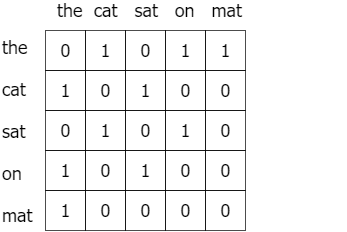

In [66]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [67]:
from keras.preprocessing.text import Tokenizer
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(tokens)
sequences=tokenizer_obj.texts_to_sequences(tokens)

In [68]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 507


In [69]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 507/507 [00:00<00:00, 309581.03it/s]


In [70]:
embedding_matrix.shape

(508, 100)

****

****

****

****

In [71]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(num_words, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

2022-05-31 18:20:13.853328: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          50800     
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 219,569
Trainable params: 168,769
Non-trainable params: 50,800
_________________________________________________________________


In [73]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [74]:
df1

,entities,lemmatization,start_char,end_char,label,explain,frequency
0,Anne H. Elliott,Anne H. Elliott,14,29,PERSON,"People, including fictional",1
1,Amnesty,Amnesty,76,83,ORG,"Companies, agencies, institutions, etc.",2
2,Andrew Johnson,Andrew Johnson,107,121,PERSON,"People, including fictional",2
3,the United States of America,the United States of America,135,163,GPE,"Countries, cities, states",7
4,May 29th 1865,May 29th 1865,167,180,DATE,Absolute or relative dates or periods,1
...,...,...,...,...,...,...,...
389,Warren Co Miss,Warren Co Miss,985,999,PERSON,"People, including fictional",1
390,1865,1865,1033,1037,DATE,Absolute or relative dates or periods,14
391,Frank E. Miller,Frank E. Miller,1042,1057,PERSON,"People, including fictional",2
392,66th,66th,1065,1069,ORDINAL,"""first"", ""second"", etc.",3


In [75]:
from keras.preprocessing import text, sequence
tokenizer = text.Tokenizer()

In [76]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 917.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=54a0045017bf390019d22576ea008921cc4525a16a86c5c06a962bfb626cb41c
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
  Created wheel for validators: filename=validators-0.19.0-py3-none-any.whl size=19553 sha256=1342cce7ad6273d8fea0772b3b54acf61fa87578766c5157b9fa876b8f55cbed
  Stored in directory: /root/.cache/pip/wheels/fe/5d/69/ff53a908b9f14fb7730a58fdede0fac4cdc

In [77]:
!conda uninstall tokenizers, transformers
!pip install transformers

Solving environment: - \ | / - \ | / - \ | / - \ failed

PackagesNotFoundError: The following packages are missing from the target environment:
  - tokenizers,
  - transformers




In [78]:

!pip install tokenizers
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.3 requires transformers<4.19,>=4.1, but you have transformers 4.19.2 which is incompatible.


In [79]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df1.drop("label", axis=1),df1.label,random_state = 0)


In [80]:
x_test.head(1)

,entities,lemmatization,start_char,end_char,explain,frequency
113,J.B. Hiserodt,J.B. Hiserodt,124,137,"People, including fictional",1


In [81]:
x_train.head(2)

,entities,lemmatization,start_char,end_char,explain,frequency
219,Jacob Schroder,Jacob Schroder,327,341,"People, including fictional",4
246,J.W. Baxter,J.W. Baxter,485,496,"Companies, agencies, institutions, etc.",3


In [82]:
tr_data=pd.DataFrame({"entities":x_train["entities"], "lemmatization":x_train["lemmatization"], "start_char":x_train["start_char"], "end_char": x_train["end_char"],"label":y_train, "explain":x_train["explain"],"frequency":x_train["frequency"]})
ts_data=pd.DataFrame({"entities":x_test["entities"], "lemmatization":x_test["lemmatization"], "start_char":x_test["start_char"], "end_char": x_test["end_char"],"label":y_test, "explain":x_test["explain"],"frequency":x_test["frequency"]})

In [83]:
df1.head(3)

,entities,lemmatization,start_char,end_char,label,explain,frequency
0,Anne H. Elliott,Anne H. Elliott,14,29,PERSON,"People, including fictional",1
1,Amnesty,Amnesty,76,83,ORG,"Companies, agencies, institutions, etc.",2
2,Andrew Johnson,Andrew Johnson,107,121,PERSON,"People, including fictional",2


In [84]:
lab=df1["label"].unique().tolist()


**Trying simpl bert model**

In [85]:
from simpletransformers.ner import NERModel , NERArgs

In [86]:
args=NERArgs()
args.num_train_epoch=5
args.learning_rate=1e-3
args.overwrite_output_dir=True
args.train_batch_size=2
args.eval_batch_size=2

In [87]:
# m=NERModel('bert', 'bert-base-cased', labels=lab, args=args, use_cuda= False)

In [88]:
# m.train_model(train_data, eval_data=test_data, acc=accuracy_score)

In [89]:
len(x_train)

295

In [90]:
len(x_test)

99

In [91]:
x_test

,entities,lemmatization,start_char,end_char,explain,frequency
113,J.B. Hiserodt,J.B. Hiserodt,124,137,"People, including fictional",1
281,ANDREW JOHNSON,ANDREW JOHNSON,97,111,"Companies, agencies, institutions, etc.",5
68,the United States of America,the United States of America,130,158,"Countries, cities, states",7
155,this 16th day,this 16th day,360,373,Absolute or relative dates or periods,2
329,20th 1865,20th 1865,814,823,Absolute or relative dates or periods,1
...,...,...,...,...,...,...
307,5 feet 6 inches,5 foot 6 inch,1353,1368,"Measurements, as of weight or distance",2
278,Frank Conner,Frank Conner,0,12,"People, including fictional",1
81,Mrs E. Montgomery,Mrs E. Montgomery,544,561,"People, including fictional",1
343,the United States,the United States,282,299,"Countries, cities, states",20


In [92]:
tokenized_test = tokenizer.texts_to_sequences(x_test)

In [93]:
tokenized_test

[[], [], [], [], [], []]

In [94]:

X_test = sequence.pad_sequences(tokenized_test)

In [95]:
X_test

array([], shape=(6, 0), dtype=int32)

In [96]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train)

In [97]:
len(x_train)

6

In [98]:
len(y_train)

295

In [99]:
len(X_test)

6

why the length of xtrain and xtest change after the transormation!!! although the padsequences is alright 

In [100]:
# history = model.fit(x_train, y_train, batch_size = 2 , validation_data = (X_test,y_test) , epochs = 20 , callbacks = [learning_rate_reduction])

****

****

********

# Hugging_Face Pipelines

**it was a mess up** Xd

In [101]:
!pip install -q torch==1.4.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cpu requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.11.0+cpu requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.
pytorch-lightning 1.6.3 requires torch>=1.8.*, but you have torch 1.4.0 which is incompatible.
kornia 0.5.8 requires torch>=1.6.0, but you have torch 1.4.0 which is incompatible.
fastai 2.6.3 requires torch<1.12,>=1.7.0, but you have torch 1.4.0 which is incompatible.
fairscale 0.4.6 requires torch>=1.8.0, but you have torch 1.4.0 which is incompatible.
allennlp 2.9.3 requires torch<1.12.0,>=1.6.0, but you have torch 1.4.0 which is incompatible.
allennlp 2.9.3 requires transformers<4.19,>=4.1, but you have transformers 4.19.2 which is incomp

In [102]:
from transformers import pipeline
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from transformers import AutoModel, AutoTokenizer

In [103]:
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english" 
model = AutoModel.from_pretrained(model_name)
tokenizerr = AutoTokenizer.from_pretrained(model_name)


Downloading:   0%|          | 0.00/998 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

**AutoTokenizer**

*This is a generic tokenizer class that will be instantiated as one of the tokenizer classes of the library when created with the AutoTokenizer.from_pretrained() class method*

In [104]:
tokens = tokenizerr(data["transcription_text"][0], return_tensors="pt")

In [105]:
tokens

{'input_ids': tensor([[  101,   129,   142,  4035,  1665,  1233,   146,  3967,   145,   119,
          9657,   117,  8244,  1202, 22752,  1193,  8222,  1115,   146,  1138,
          2373,  1103, 25072, 22684,  3010,  1118,  3217,  2921,  1697,  1104,
          1103,  1244,  1311,  1104,  1738,  1113,  1318, 17333,  6127,  1105,
          1115,   146,  1821,  1136,  2589,  1174,  1121,  1103,  6245,  1104,
          1115, 22684,  1118,  1251,  1141,  1104,  1103,  7840, 12408,  1175,
          1394,  1189,   119,   156, 12821,  4558,  1106,  1105,  4841, 25626,
          1196,  1143,  1120,  1142, 15757,  1285,  1104, 14152,  1830,  6127,
           156,   119, 20280, 12786, 15379,  7085, 19815,   117, 23232,   138,
           119,   145,   119,   142,   119,   164,   164,  3077,   131,   123,
          9848,  7143, 13182,   166,   166,  3967,   145,  9657,  1244,  1311,
          1104,  1738,   146,  3967,   145,  9657,   117,  1104,  1103,  1574,
          1104, 26427,   117,  1426,  

In [106]:
ner_pipe = pipeline(task='ner', model=model_name,tokenizer=tokenizerr)

In [107]:
L=[]
for ent in ner_pipe(data["transcription_text"][0]):
    L.append(ent)
L[:5]

[{'entity': 'I-PER',
  'score': 0.9989004,
  'index': 7,
  'word': 'Anne',
  'start': 14,
  'end': 18},
 {'entity': 'I-PER',
  'score': 0.9988207,
  'index': 8,
  'word': 'H',
  'start': 19,
  'end': 20},
 {'entity': 'I-PER',
  'score': 0.99461913,
  'index': 9,
  'word': '.',
  'start': 20,
  'end': 21},
 {'entity': 'I-PER',
  'score': 0.9994429,
  'index': 10,
  'word': 'Elliott',
  'start': 22,
  'end': 29},
 {'entity': 'I-MISC',
  'score': 0.837695,
  'index': 22,
  'word': 'Amnesty',
  'start': 76,
  'end': 83}]

*thanks god (after 2hours of unsigned  error)*

****

**trying other model ! it's getting better**

In [108]:
pipe = pipeline(task='ner', model="dslim/bert-base-NER-uncased")

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [109]:
L=[]
for ent in pipe(data["transcription_text"][0]):
    L.append(ent)
L[:5]

[{'entity': 'B-PER',
  'score': 0.994024,
  'index': 6,
  'word': 'anne',
  'start': 14,
  'end': 18},
 {'entity': 'I-PER',
  'score': 0.9914391,
  'index': 7,
  'word': 'h',
  'start': 19,
  'end': 20},
 {'entity': 'I-PER',
  'score': 0.94614685,
  'index': 8,
  'word': '.',
  'start': 20,
  'end': 21},
 {'entity': 'I-PER',
  'score': 0.9913291,
  'index': 9,
  'word': 'elliott',
  'start': 22,
  'end': 29},
 {'entity': 'B-PER',
  'score': 0.99484974,
  'index': 24,
  'word': 'andrew',
  'start': 107,
  'end': 113}]

****

****